In [1]:
%load_ext autoreload
%autoreload 2


- Two major problems
  - Spatial data (and others) has no fixed reference. There should be a transform/rot/scale lstsq after main pinning
  - There is no current incentive for cells to interact with an absolute env

In [2]:
import os

import matplotlib as mpl
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='dark', palette='colorblind')


# Running the Model

In [3]:
# # Read data files
# # adatas = celltrip.utility.processing.read_adatas(
# #     's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad',
# #     's3://nkalafut-celltrip/MERFISH_Bench/spatial.h5ad',
# #     backed=True)
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH/spatial.h5ad',
#     backed=True)
# # adatas = [
# #     celltrip.utility.processing.merge_adatas(
# #         *celltrip.utility.processing.read_adatas(*[
# #             f's3://nkalafut-celltrip/Flysta3D/{p}_{m}.h5ad'
# #             for p in ('E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b')],
# #             backed=True), backed=True)
# #     for m in ('expression', 'spatial')]
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH-250804-1', 400
# # prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Flysta3D-250729', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# # samples = adatas[0].obs.loc[adatas[0].obs['development'] == 'E14-16h_a'].index
# # samples = samples[np.random.choice(samples.shape[0], 1_000, replace=False)]  # Subsample
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH_Bench/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250807', 300
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [5]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH-250804-1', 400
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [3]:
# Read data files
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/VirtualCell/vcc_flt_data.h5ad',
    backed=True)
# Model location and name (should be prefix for .weights, .pre, and .mask file)
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/VCC-250816-1', 100
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# Subset and preprocess the data (Use partition cols here to select data)
samples = adatas[0].obs.index[adatas[0].obs['target_gene']=='non-targeting']  # Only non-targeting
np.random.seed(42)
samples = samples[np.random.choice(samples.shape[0], 1_000, replace=False)]  # Subsample
m1, = preprocessing.transform([ad[samples].X for ad in adatas])
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # Doesn't eval log_std now, TODO, examine why so much better in train mode
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


RuntimeError: Error(s) in loading state_dict for PPO:
	Missing key(s) in state_dict: "pinning.0.mlp.1.weight", "pinning.0.mlp.1.bias", "pinning.0.mlp.2.weight", "pinning.0.mlp.4.weight", "pinning.0.mlp.4.bias". 
	size mismatch for actor_critic.self_pos_embed.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for actor_critic.self_pos_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.self_feat_embed.weight: copying a param with shape torch.Size([64, 512]) from checkpoint, the shape in current model is torch.Size([32, 512]).
	size mismatch for actor_critic.self_feat_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_pos_embed.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for actor_critic.node_pos_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_feat_embed.weight: copying a param with shape torch.Size([64, 512]) from checkpoint, the shape in current model is torch.Size([32, 512]).
	size mismatch for actor_critic.node_feat_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.self_embed.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.self_embed.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.self_embed.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for actor_critic.self_embed.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.self_embed.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.self_embed.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_embed.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_embed.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_embed.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for actor_critic.node_embed.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_embed.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.node_embed.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.attention.in_proj_weight: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([96, 32]).
	size mismatch for actor_critic.residual_attention_blocks.0.attention.in_proj_bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for actor_critic.residual_attention_blocks.0.attention.out_proj.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for actor_critic.residual_attention_blocks.0.attention.out_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.norms.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.norms.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.norms.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.norms.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.norms.2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.norms.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.residual_attention_blocks.0.mlp.0.weight: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([128, 32]).
	size mismatch for actor_critic.residual_attention_blocks.0.mlp.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for actor_critic.residual_attention_blocks.0.mlp.2.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([32, 128]).
	size mismatch for actor_critic.residual_attention_blocks.0.mlp.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.actor_decider.decider.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.actor_decider.decider.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic.actor_decider.decider.3.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for actor_critic.actor_decider.decider.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for actor_critic.actor_decider.decider.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for actor_critic.actor_decider.decider.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for actor_critic.actor_decider.decider.7.weight: copying a param with shape torch.Size([16, 128]) from checkpoint, the shape in current model is torch.Size([8, 64]).
	size mismatch for actor_critic.actor_decider.decider.7.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for actor_critic.critic_decider.1.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for actor_critic_old.self_pos_embed.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for actor_critic_old.self_pos_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.self_feat_embed.weight: copying a param with shape torch.Size([64, 512]) from checkpoint, the shape in current model is torch.Size([32, 512]).
	size mismatch for actor_critic_old.self_feat_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_pos_embed.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for actor_critic_old.node_pos_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_feat_embed.weight: copying a param with shape torch.Size([64, 512]) from checkpoint, the shape in current model is torch.Size([32, 512]).
	size mismatch for actor_critic_old.node_feat_embed.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.self_embed.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.self_embed.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.self_embed.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for actor_critic_old.self_embed.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.self_embed.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.self_embed.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_embed.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_embed.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_embed.3.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for actor_critic_old.node_embed.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_embed.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.node_embed.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.attention.in_proj_weight: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([96, 32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.attention.in_proj_bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.attention.out_proj.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.attention.out_proj.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.norms.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.norms.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.norms.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.norms.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.norms.2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.norms.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.mlp.0.weight: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([128, 32]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.mlp.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.mlp.2.weight: copying a param with shape torch.Size([64, 256]) from checkpoint, the shape in current model is torch.Size([32, 128]).
	size mismatch for actor_critic_old.residual_attention_blocks.0.mlp.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.actor_decider.decider.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.actor_decider.decider.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for actor_critic_old.actor_decider.decider.3.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for actor_critic_old.actor_decider.decider.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for actor_critic_old.actor_decider.decider.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for actor_critic_old.actor_decider.decider.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for actor_critic_old.actor_decider.decider.7.weight: copying a param with shape torch.Size([16, 128]) from checkpoint, the shape in current model is torch.Size([8, 64]).
	size mismatch for actor_critic_old.actor_decider.decider.7.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for actor_critic_old.critic_decider.1.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for input_standardization.mean: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for input_standardization.square_mean: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for input_standardization.std: copying a param with shape torch.Size([544]) from checkpoint, the shape in current model is torch.Size([528]).
	size mismatch for pinning.0.mlp.0.weight: copying a param with shape torch.Size([512, 16]) from checkpoint, the shape in current model is torch.Size([16, 8]).
	size mismatch for pinning.0.mlp.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for pinning.0.first_layer.weight: copying a param with shape torch.Size([512, 16]) from checkpoint, the shape in current model is torch.Size([16, 8]).
	size mismatch for pinning.0.first_layer.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for pinning.0.input_standardization.mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for pinning.0.input_standardization.square_mean: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for pinning.0.input_standardization.std: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([8]).

In [9]:
m1.std(axis=0)**2

array([2.6494783e+03, 1.1103351e+02, 8.7765907e+01, 8.6087532e+01,
       4.8938564e+01, 4.6210587e+01, 2.8684759e+01, 2.4815886e+01,
       1.8697742e+01, 2.4207035e+01, 2.0233944e+01, 1.8718164e+01,
       1.6117620e+01, 1.3921483e+01, 1.4243707e+01, 1.2950137e+01,
       1.0561754e+01, 9.3304672e+00, 9.3343029e+00, 7.8923779e+00,
       8.6802206e+00, 2.6087544e+00, 1.7718021e+00, 4.8201160e+00,
       5.8380694e+00, 6.1234756e+00, 5.2470737e+00, 5.3093529e+00,
       5.2439690e+00, 1.1566570e+00, 4.5145097e+00, 4.9338937e+00,
       2.6870551e+00, 3.7610550e+00, 3.7887242e+00, 3.4646006e+00,
       2.1401799e+00, 3.3070560e+00, 2.5749211e+00, 2.2933509e+00,
       3.2471955e+00, 1.8388801e+00, 1.8202786e+00, 3.1143005e+00,
       3.0706682e+00, 2.6978979e+00, 2.9154963e+00, 2.8366001e+00,
       1.5758294e+00, 2.9711056e+00, 2.1371586e+00, 2.3054917e+00,
       1.2019746e+00, 2.1411479e+00, 2.0093107e+00, 1.7678386e+00,
       1.7812061e+00, 1.9091988e+00, 1.6899233e+00, 1.7662851e

In [5]:
preprocessing.pca_class[0].explained_variance_

array([2714.8623   ,  113.61517  ,   91.05531  ,   83.051315 ,
         62.358795 ,   51.32649  ,   41.78105  ,   36.27427  ,
         32.82086  ,   29.075294 ,   25.652374 ,   21.76027  ,
         20.431076 ,   17.992477 ,   16.625929 ,   16.492283 ,
         15.088121 ,   13.82649  ,   13.735816 ,   13.057499 ,
         12.50759  ,   11.793239 ,   11.536904 ,   11.202915 ,
         10.106038 ,    9.408176 ,    9.191722 ,    8.9749365,
          8.820243 ,    8.606933 ,    8.497672 ,    8.172613 ,
          7.9988604,    7.8238897,    7.7498546,    7.5373726,
          7.4864564,    7.3246484,    7.289196 ,    7.1577797,
          7.120385 ,    7.007782 ,    6.906146 ,    6.8484335,
          6.735418 ,    6.68469  ,    6.623705 ,    6.529702 ,
          6.4077034,    6.384796 ,    6.335131 ,    6.28794  ,
          6.2687087,    6.1799417,    6.1384945,    6.1020865,
          6.0511775,    6.019424 ,    6.0061736,    5.9699144,
          5.9276767,    5.905324 ,    5.86072  ,    5.8

In [22]:
np.sqrt(preprocessing.pca_class[0].explained_variance_.sum())

np.float32(75.39117)

In [20]:
m1.shape[1] / np.sqrt(preprocessing.pca_class[0].explained_variance_.sum())

np.float32(6.7912464)

In [29]:
(m1 * m1.shape[1] / np.sqrt(preprocessing.pca_class[0].explained_variance_).sum()).std(axis=0)

array([21.82345   ,  4.467559  ,  3.9719732 ,  3.9338105 ,  2.9659839 ,
        2.8821342 ,  2.2707477 ,  2.1120682 ,  1.8333167 ,  2.0859988 ,
        1.9071432 ,  1.8343186 ,  1.7021343 ,  1.5819248 ,  1.6001283 ,
        1.5257393 ,  1.3778791 ,  1.2950752 ,  1.2953416 ,  1.1910967 ,
        1.249133  ,  0.6847937 ,  0.56435305,  0.9308338 ,  1.0244195 ,
        1.0491614 ,  0.97118443,  0.9769315 ,  0.97089726,  0.4559798 ,
        0.90084213,  0.941756  ,  0.6949945 ,  0.82223886,  0.8252582 ,
        0.78916895,  0.6202522 ,  0.7710174 ,  0.6803389 ,  0.64206403,
        0.764007  ,  0.57493657,  0.5720213 ,  0.7482099 ,  0.74295014,
        0.69639534,  0.72393477,  0.7140727 ,  0.5322279 ,  0.7308058 ,
        0.61981446,  0.6437615 ,  0.4648264 ,  0.62039226,  0.60098934,
        0.5637214 ,  0.5658487 ,  0.58582604,  0.5511588 ,  0.5634735 ,
        0.61639273,  0.6147388 ,  0.6037706 ,  0.6012713 ,  0.61123985,
        0.6868782 ,  0.6459008 ,  0.6073304 ,  0.5663611 ,  0.56

In [ ]:
# current_genes = adatas[0].var.index[preprocessing.filter_mask[0]]
# gene_list = list(set(current_genes).intersection(['TMSB4X', 'PRCP', 'TADA1']))
# gene_idx = [np.argwhere(adatas[0].var.index == gene)[0][0] for gene in gene_list]


In [ ]:
# policy.train()
# env.train()


In [ ]:
# Run policy to convergence, and get pinning function
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1, :, :env.dim].cpu()
target_state = env.modalities[env.target_modalities[0]].cpu()


In [ ]:
ret[3]


{'distance': 0.0,
 'pinning': -957549.375,
 'origin': 0.0,
 'bound': 0.0,
 'velocity': -3.9922990798950195,
 'action': -11.348600387573242}

In [ ]:
# # Two modality imputation
# pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]
# reduction = lambda X: X


In [ ]:
# One modality imputation
pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()  # TODO: Maybe pinning using standardization?
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=0)[0]
reduction = lambda X: X

# Add reduction method
# import sklearn; red = sklearn.decomposition.PCA(n_components=2).fit(inverse_transform(target_state.numpy()))  # PCA True
import umap; red = umap.UMAP().fit(inverse_transform(target_state.numpy()))  # UMAP True
# import umap; red = umap.UMAP().fit(inverse_transform(pinning_function(steady_state)))  # UMAP CT
reduction = lambda X: red.transform(X)


In [ ]:
# # Identity
# pinning_function = lambda X: X.numpy()
# inverse_transform = lambda X: X
# reduction = lambda X: X


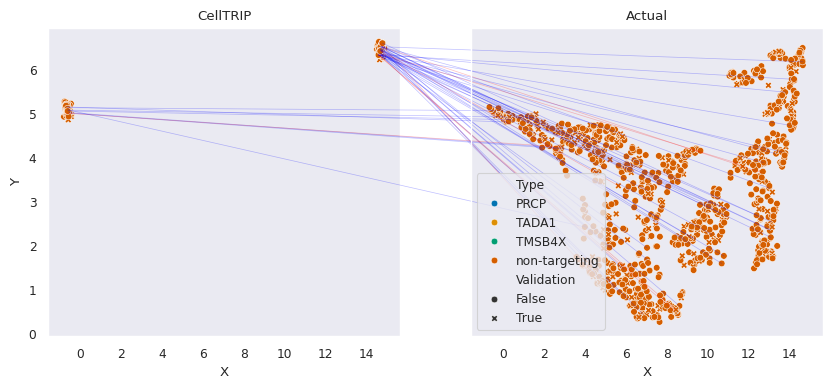

In [ ]:
# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = reduction(inverse_transform(pinning_function(steady_state)))[..., :2]
df[['X_true', 'Y_true']] = reduction(inverse_transform(target_state.numpy()))[..., :2]
df['Type'] = adatas[0].obs.loc[samples, 'target_gene']  # 'target_gene', 'layer', 'pattern_gp_label', 'annotation'
df['Validation'] = ~pd.DataFrame(mask, index=adatas[0].obs.index).loc[samples]
# df = df.loc[df['Validation']]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', style='Validation', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', style='Validation', legend=True, ax=axs[1])
for i in np.random.choice(df.shape[0], min(50, df.shape[0]), replace=False):
    patch = ConnectionPatch(
        xyA=df.iloc[i][['X_pred', 'Y_pred']].to_numpy(), xyB=df.iloc[i][['X_true', 'Y_true']].to_numpy(),
        coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1],
        color='blue' if not df.iloc[i]['Validation'] else 'red', lw=.5, alpha=.25)
    axs[1].add_patch(patch)
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
fig.show()


In [ ]:
# Intra-type Error
df['MSE'] = np.mean(np.square(inverse_transform(pinning_function(steady_state)) - inverse_transform(target_state.numpy())), axis=-1)
df_mse = df[['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse['Validation MSE'] = df.loc[df['Validation'], ['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse


,MSE,Validation MSE
Type,,
non-targeting,762343.5,745562.1875


In [ ]:
Y_pred = inverse_transform(pinning_function(steady_state))
Y_true = inverse_transform(target_state.numpy())


In [ ]:
import scipy
record = {'gene': [], 'corr': [], 'p': []}
for i in range(Y_true.shape[1]):
    res = scipy.stats.pearsonr(Y_pred[:, i], Y_true[:, i])
    corr, p = res.statistic, res.pvalue
    record['gene'].append(adatas[0].var.index[i])
    record['corr'].append(corr)
    record['p'].append(p)
df = pd.DataFrame(record)
sig_frac = (df.dropna()['p'] <= 5e-2).mean()
print(f'{100*sig_frac:.0f}% significant correlations')


/tmp/ipykernel_66116/1283173573.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = scipy.stats.pearsonr(Y_pred[:, i], Y_true[:, i])


88% significant correlations


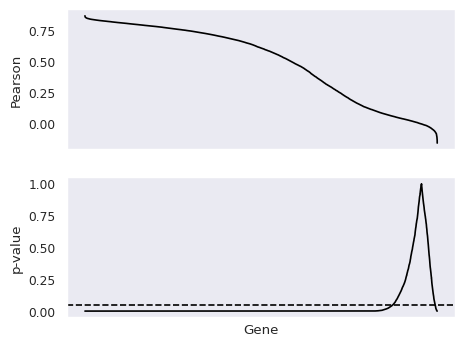

In [ ]:
df_sort = df.dropna().sort_values('corr', ascending=False)
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
axs[0].plot(df_sort['gene'], df_sort['corr'], color='black')
axs[0].set(ylabel='Pearson')
axs[1].plot(df_sort['gene'], df_sort['p'], color='black')
axs[1].set(ylabel='p-value', xlabel='Gene', xticks=[])
axs[1].axhline(y=5e-2, ls='--', color='black')


In [ ]:
ret1 = celltrip.utility.processing.split_state(env.get_state(), idx=[0, 1, 2], sample_strategy=None)


In [ ]:
ret1[0].shape


torch.Size([3, 16])

In [ ]:
ret1[1].shape


torch.Size([1000, 16])

In [ ]:
ret1[2].shape


torch.Size([3, 1000])

In [ ]:
ret1[0]


tensor([[-2.6845e+01,  3.3675e+02,  9.4929e+01, -3.5214e+01, -2.5867e+01,
         -4.4298e+01, -6.1968e+00, -6.5851e+01,  5.7980e-01, -7.1938e-01,
         -4.7046e-01,  9.8468e-01,  1.0000e+00,  7.7092e-01, -6.7891e-01,
          3.6599e-01],
        [ 4.2863e+01,  1.7187e+02,  1.0484e+02,  2.7712e+01, -4.7690e+01,
          5.4135e+00,  9.0928e+01,  1.8734e+01, -1.7818e-01,  3.8760e-02,
          7.7608e-01, -6.4833e-01, -1.7844e-01, -6.8265e-01,  4.0216e-02,
          8.9279e-01],
        [-2.0073e+01,  2.4768e+02, -4.5375e+00, -8.6513e+01,  1.7983e+01,
         -6.8214e+01, -5.1112e+01,  1.3335e+00, -7.4120e-01,  6.2583e-01,
         -3.6333e-01, -5.7816e-01,  7.3786e-01,  8.3910e-01,  5.8020e-01,
          3.2869e-01]], device='cuda:0')

In [ ]:
ret1[1]


tensor([[-2.6845e+01,  3.3675e+02,  9.4929e+01,  ...,  7.7092e-01,
         -6.7891e-01,  3.6599e-01],
        [ 4.2863e+01,  1.7187e+02,  1.0484e+02,  ..., -6.8265e-01,
          4.0216e-02,  8.9279e-01],
        [-2.0073e+01,  2.4768e+02, -4.5375e+00,  ...,  8.3910e-01,
          5.8020e-01,  3.2869e-01],
        ...,
        [-6.6236e+01,  4.2150e+02,  5.0093e+00,  ..., -7.8590e-01,
          1.0908e-01, -8.6003e-01],
        [-1.3273e+01,  3.7522e+02, -1.3556e+01,  ...,  7.8873e-01,
         -6.6712e-01, -9.3519e-01],
        [-4.2329e+01,  7.4115e+01,  3.6417e+01,  ..., -3.9320e-01,
         -1.0000e+00,  8.8199e-01]], device='cuda:0')

In [ ]:
ret1[2]


tensor([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False]], device='cuda:0')

In [ ]:
ret2 = celltrip.utility.processing.split_state(env.get_state(), idx=[0, 1, 2])


In [ ]:
ret2[0].shape


torch.Size([3, 16])

In [ ]:
ret2[1].shape


torch.Size([1000, 16])

In [ ]:
# ret2[2].shape


In [ ]:
ret2[0]


tensor([[-2.6845e+01,  3.3675e+02,  9.4929e+01, -3.5214e+01, -2.5867e+01,
         -4.4298e+01, -6.1968e+00, -6.5851e+01,  5.7980e-01, -7.1938e-01,
         -4.7046e-01,  9.8468e-01,  1.0000e+00,  7.7092e-01, -6.7891e-01,
          3.6599e-01],
        [ 4.2863e+01,  1.7187e+02,  1.0484e+02,  2.7712e+01, -4.7690e+01,
          5.4135e+00,  9.0928e+01,  1.8734e+01, -1.7818e-01,  3.8760e-02,
          7.7608e-01, -6.4833e-01, -1.7844e-01, -6.8265e-01,  4.0216e-02,
          8.9279e-01],
        [-2.0073e+01,  2.4768e+02, -4.5375e+00, -8.6513e+01,  1.7983e+01,
         -6.8214e+01, -5.1112e+01,  1.3335e+00, -7.4120e-01,  6.2583e-01,
         -3.6333e-01, -5.7816e-01,  7.3786e-01,  8.3910e-01,  5.8020e-01,
          3.2869e-01]], device='cuda:0')

In [ ]:
ret2[1]


tensor([[-2.6845e+01,  3.3675e+02,  9.4929e+01,  ...,  7.7092e-01,
         -6.7891e-01,  3.6599e-01],
        [ 4.2863e+01,  1.7187e+02,  1.0484e+02,  ..., -6.8265e-01,
          4.0216e-02,  8.9279e-01],
        [-2.0073e+01,  2.4768e+02, -4.5375e+00,  ...,  8.3910e-01,
          5.8020e-01,  3.2869e-01],
        ...,
        [-6.6236e+01,  4.2150e+02,  5.0093e+00,  ..., -7.8590e-01,
          1.0908e-01, -8.6003e-01],
        [-1.3273e+01,  3.7522e+02, -1.3556e+01,  ...,  7.8873e-01,
         -6.6712e-01, -9.3519e-01],
        [-4.2329e+01,  7.4115e+01,  3.6417e+01,  ..., -3.9320e-01,
         -1.0000e+00,  8.8199e-01]], device='cuda:0')

In [ ]:
# ret2[2]


[Text(0.5, 1.0, 'TMSB4X'), Text(0.5, 0, 'Observed'), Text(0, 0.5, 'CellTRIP')]

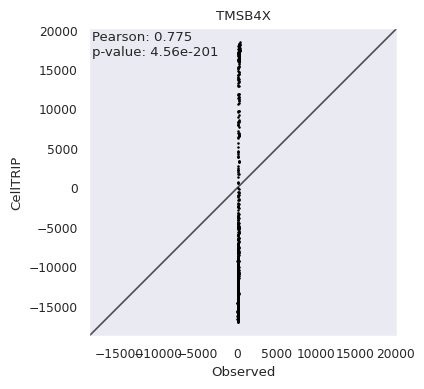

In [ ]:
# idx = df['corr'].sort_values().dropna().iloc[::-1].index[0]
idx = np.argwhere(df['gene'] == 'TMSB4X').flatten()[0]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Main scatter
ax.scatter(Y_true[:, idx], Y_pred[:, idx], s=1, color='black')
# Extra text
corr, p = df.iloc[idx][['corr', 'p']]
ax.text(.01, .99, f'Pearson: {corr:.3f}\np-value: {p:.2e}', ha='left', va='top', transform=ax.transAxes)
# Add y=x line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set(title=adatas[0].var.index[idx], xlabel='Observed', ylabel='CellTRIP')


In [ ]:
ret[-1][-1][..., env.dim:].mean(dim=0)


tensor([-0.0064,  0.2019,  0.0120, -0.0094,  0.0349,  0.0392, -0.0189, -0.0678],
       device='cuda:0')

In [ ]:
steady_state.mean(dim=0)


tensor([-2.1732e+01,  2.4860e+02,  7.2409e+00, -7.7535e+00,  6.5222e+00,
        -2.2331e-01, -1.8289e+01, -5.9147e+01])

In [ ]:
def gene_perturbation(adata, steady_state, genes_to_perturb, preprocessing, modality=0, factor=0):  # adatas[0][samples_flt1], max_steps=1_000
    # Set up env
    env.reset()
    env.set_positions(steady_state.to(env.device))
    env.set_velocities(0*env.get_velocities())
    # Find feature
    features = [np.argwhere(adata.var.index == gene).flatten()[0] for gene in genes_to_perturb]
    # Get knockdowns
    iso_modality = preprocessing.transform(adata.X[:], subset_features=features, subset_modality=modality)[0]  # TODO: Send to pramod with [:] addition
    iso_modality = torch.tensor(iso_modality).to(env.device)
    env.modalities[modality] -= iso_modality - factor*iso_modality
    # Simulate
    ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)

    return ret[-1]


In [ ]:
# Permute
group_pert = gene_perturbation(adatas[0][samples], steady_state, ['TMSB4X'], preprocessing, modality=0, factor=0)


/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


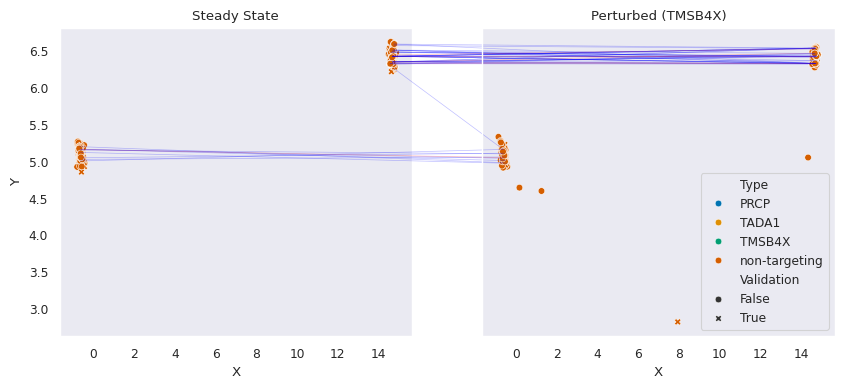

In [ ]:
# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_init', 'Y_init']] = reduction(inverse_transform(pinning_function(group_pert[0, :, :env.dim])))[..., :2]
df[['X_final', 'Y_final']] = reduction(inverse_transform(pinning_function(group_pert[-1, :, :env.dim])))[..., :2]
df['Type'] = adatas[0].obs.loc[samples, 'target_gene']  # 'target_gene', 'layer', 'pattern_gp_label', 'annotation'
df['Validation'] = ~pd.DataFrame(mask, index=adatas[0].obs.index).loc[samples]
# df = df.loc[df['Validation']]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_init', y='Y_init', hue='Type', style='Validation', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_final', y='Y_final', hue='Type', style='Validation', legend=True, ax=axs[1])
for i in np.random.choice(df.shape[0], min(50, df.shape[0]), replace=False):
    patch = ConnectionPatch(
        xyA=df.iloc[i][['X_init', 'Y_init']].to_numpy(), xyB=df.iloc[i][['X_final', 'Y_final']].to_numpy(),
        coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1],
        color='blue' if not df.iloc[i]['Validation'] else 'red', lw=.5, alpha=.25)
    axs[1].add_patch(patch)
axs[0].set(title='Steady State', xlabel='X', ylabel='Y')
axs[1].set(title='Perturbed (TMSB4X)', xlabel='X')
fig.show()


In [ ]:
# Permute
start_state = steady_state.clone()
start_state[0] = start_state[600]  # 600 for VCC, 1 for MERFISH
# Set to steady state
env.reset()  # .store_vals().set_termination_conds(exclusive=True, max_time=True) ; env.max_time = 10
env.set_velocities(0*env.get_velocities())
env.set_positions(start_state.to('cuda'))
# Run and reset
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
transition_states = ret[-1][..., :env.dim].cpu()


In [ ]:
# Convert select points to feature space
use_states = list(map(int, np.linspace(0, transition_states.shape[0]-1-3_000, 9)))
filtered_transition_states = transition_states[use_states]
pinned_transition_states = reduction(
    inverse_transform(
        pinning_function(
            filtered_transition_states.reshape((-1, env.dim))
        )
    )
).reshape((*filtered_transition_states.shape[:-1], -1))


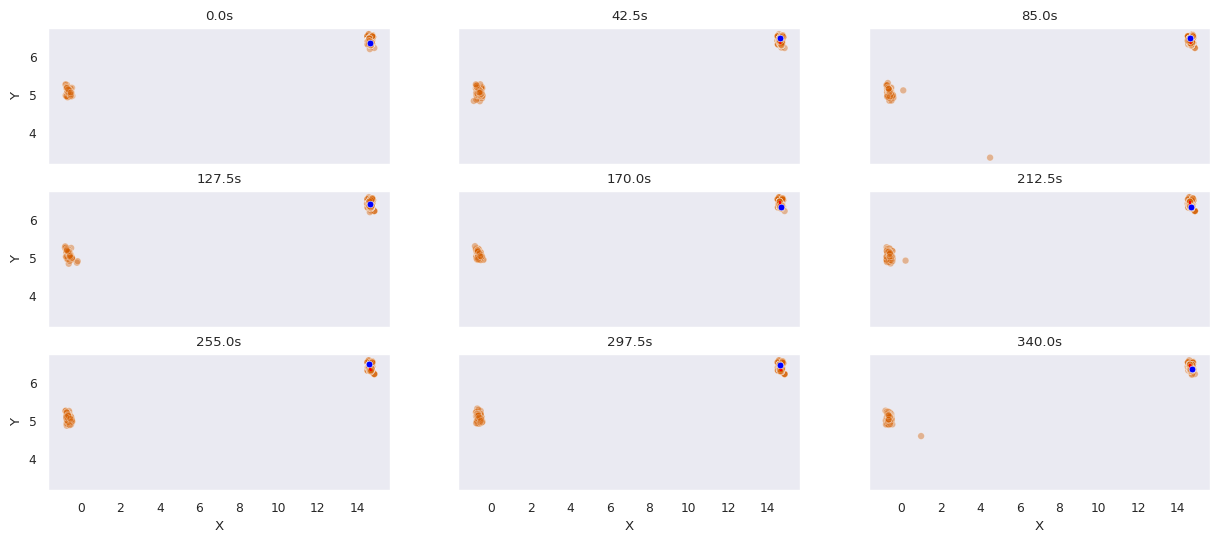

In [ ]:
# Get timepoints
dfs = []
for i, timepoint in enumerate(use_states):
    timepoint = int(timepoint)
    dfs.append(pd.DataFrame(index=samples))
    dfs[-1][['X', 'Y']] = pinned_transition_states[i]
    dfs[-1]['Type'] = adatas[0].obs.loc[samples, 'target_gene']
    dfs[-1]['Timepoint'] = timepoint
    dfs[-1]['Perturbed'] = False
    dfs[-1].loc[samples[0], 'Perturbed'] = True
df = pd.concat(dfs, axis=0)
# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
unique_timepoints = df['Timepoint'].unique()
target_point = 0; target_point_positions = []
for i, timepoint in enumerate(unique_timepoints):
    df_filter = df.loc[df['Timepoint'] == timepoint]
    target_point_positions.append(df_filter.loc[[samples[target_point]]])
    sns.scatterplot(df_filter, x='X', y='Y', hue='Type', alpha=.4, legend=False, ax=axs[i])
    for j in range(i):
        axs[i].arrow(
            *target_point_positions[j][['X', 'Y']].to_numpy().flatten(),
            *(target_point_positions[j+1][['X', 'Y']].to_numpy() - target_point_positions[j][['X', 'Y']].to_numpy()).flatten(),
            color='red', lw=1)
    sns.scatterplot(df_filter.loc[[samples[target_point]]], x='X', y='Y', color='blue', alpha=1., legend=False, ax=axs[i])
    axs[i].set(title=f'{timepoint*env.delta:.1f}s', xlabel='X', ylabel='Y')
fig.show()


In [ ]:
assert False


AssertionError: 

# Running out-of-scope data

In [ ]:
# Load the external dataset
adata = celltrip.utility.processing.read_adatas(
    # 's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad', backed=True)[0]
    '../data/MERFISH_Bench/sc_data.h5ad', backed=True)[0]
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Subset and preprocess the data (Use partition cols here to select data)
samples = adata.obs.index
m1, = preprocessing.transform(adata[samples].X, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[2]).eval().to('cuda')  # pinning=False for lstq pinning
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [ ]:
# Run policy to convergence
env.disable_rewards(); env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()
# Get pinning and inverse
pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]


In [ ]:
# inverse_transform = lambda X: X


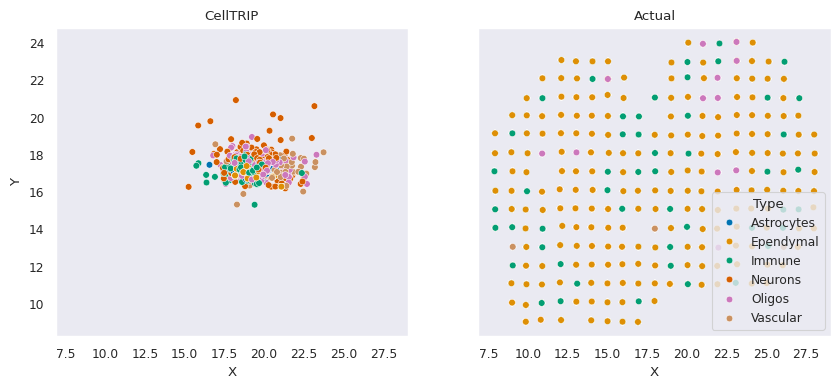

In [ ]:
# Plot imputed
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = inverse_transform(pinning_function(steady_state))[..., :2]
df[['X_true', 'Y_true']] = adata.obs['spot'].str.split('x', expand=True).astype(float)
df['Type'] = adata.obs['cellType']  # pattern_gp_label, HMRF_k3_b.40
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', legend=True, ax=axs[1])
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
fig.show()
